In [1]:
import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
import numpy as np
from torchvision import transforms, utils
from torch.utils.data.sampler import SubsetRandomSampler
import torch.optim as optim
import matplotlib.pyplot as plt
import latent_plot as lp
from torch.autograd import Variable
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
import copy


import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200
from data_loader import FundusDataLoader

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
csv_path = '/home/vip/sayan-mandal/datasets/obj_criteria/20200619-objective.csv'
img_path = '/home/vip/sayan-mandal/datasets/obj_criteria/good_reduced/'

FD = FundusDataLoader(csv_path, img_path,transform=transforms.Compose([transforms.Resize(224), transforms.ToTensor()]))

#random sampler
batch_size = 128
validation_split = .2
shuffle_dataset = True
random_seed= 42

# Creating data indices for training and validation splits:
dataset_size = len(FD)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(FD, batch_size=batch_size, sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(FD, batch_size=batch_size, sampler=valid_sampler)


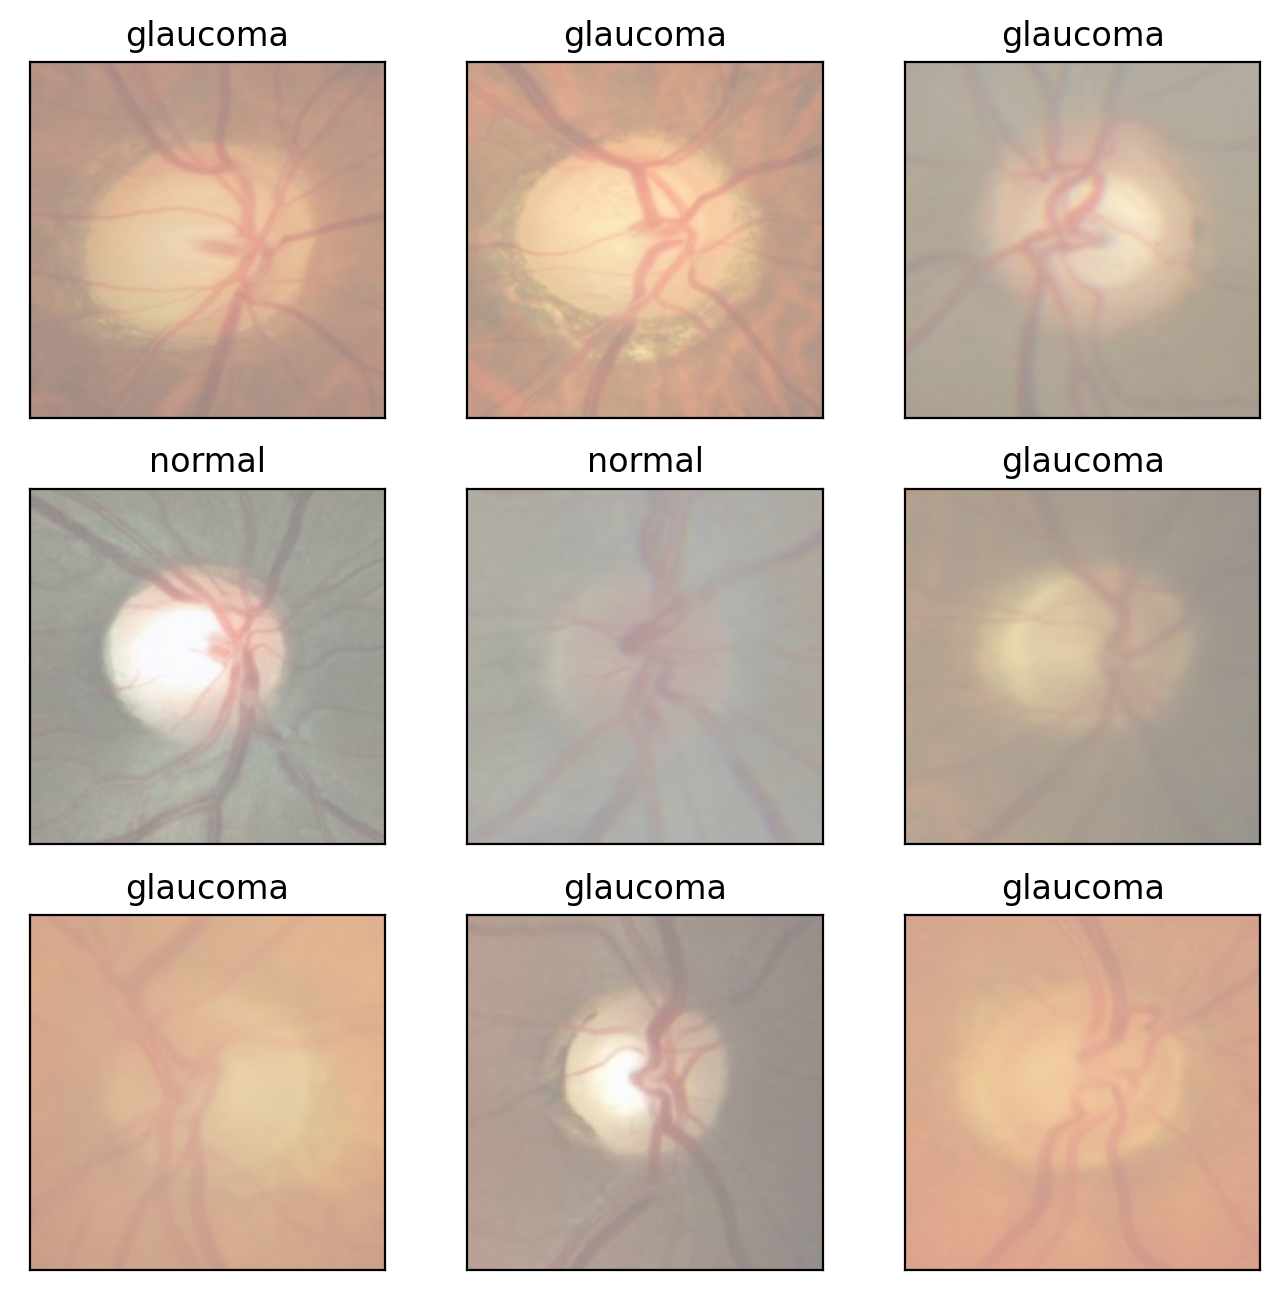

In [4]:
#Utility functions to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  
    plt.imshow(np.transpose(img, (1, 2, 0))) 

 
#Define the image classes
classes = ['normal','glaucoma']

#Obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

#Plot the images
fig = plt.figure(figsize=(8, 8))
# display 20 images
for idx in np.arange(9):
    ax = fig.add_subplot(3, 3, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

In [5]:
#kl divergence loss
#lossfunc = F.mse_loss(y,x)

def criterion(y, x, mu, logvar):
    # recontruction loss
    recon = F.binary_cross_entropy(y,data)
    # kl divergence between Q(z|x) ~ N(mu, sigma) and P(z) ~ N(0, I)
    kl = -0.5*torch.mean(1+logvar-mu.pow(2) - logvar.exp()).mean()
    return recon + 0.01*kl, recon, kl

In [6]:
class VAE(nn.Module):
    def __init__(self, in_shape, n_latent):
        super().__init__()
        self.in_shape = in_shape
        self.n_latent = n_latent
        c,h,w = in_shape
        self.z_dim = h//2**2 # receptive field downsampled 2 times
        self.encoder = nn.Sequential(
            nn.Conv2d(c, 32, kernel_size=4, stride=2, padding=1),  # 32, 112, 112
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),  # 64, 56, 56
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # 128, 28, 28
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Flatten()
        )
        self.fc1 = nn.Linear(128 * 28**2, n_latent)
        self.fc2 = nn.Linear(128 * 28**2, n_latent)
        self.fc3 = nn.Linear(n_latent, 128 * 28**2)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def sample_z(self, mean, logvar):
        stddev = logvar.mul(0.5).cuda()
        noise = Variable(torch.randn(*mean.size())).cuda()
        return (noise * stddev) + mean

    def bottleneck(self, h):
        mean, logvar = self.fc1(h), self.fc2(h)
        z = self.sample_z(mean, logvar)
        return z, mean, logvar

    def encode(self, x):
        x = self.encoder(x)
        z, mean, logvar = self.bottleneck(x)
        return z, mean, logvar

    def decode(self, z):
        out = self.fc3(z)
        out = out.view(out.shape[0], 128, 28, 28)
        out = self.decoder(out)
        return out

    def forward(self, x):
        z,mean, logvar = self.encode(x)
        out = self.decode(z)
        return out, mean, logvar


#Instantiate the model
model = VAE((3,224,224),2).cuda()
print(model)

VAE(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Flatten(start_dim=1, end_dim=-1)
  )
  (fc1): Linear(in_features=100352, out_features=2, bias=True)
  (fc2): Linear(in_features=100352, out_features=2, bias=True)
  (fc3): Linear(in_features=2, out_features=100352, bias=True)
  (decoder): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True

In [7]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
epochs = 50
ep,lss,kll,bcel, vlss,vkll,vbcel = [],[],[],[],[],[],[]
best_loss = float('inf')
for e in range(epochs):
    model.train()
    tr_loss = tr_bce = tr_kld = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = Variable(data).cuda()
        optimizer.zero_grad()
        y, mu, sig = model(data) # y = reconstructed image
        loss,bce,kld = criterion(y, data, mu, sig)
        loss.backward()
        optimizer.step()
        tr_loss += loss.item()
        tr_bce += bce.item()
        tr_kld += kld.item()

    #validation
    model.eval()
    val_loss = val_bce = val_kld = 0
    with torch.no_grad():
        for data, _ in validation_loader:
            data = Variable(data).cuda()
            y, mu, sig = model(data)
            loss,bce,kld = criterion(y, data, mu, sig)
            val_loss += loss.item()
            val_bce += bce.item()
            val_kld += kld.item()
            
    if tr_loss + val_loss < best_loss:
        best_loss = tr_loss + val_loss
        best_model = copy.deepcopy(model)
        
    to_print = "Epoch[{}/{}], Train Loss: {:.3f} {:.3f} {:.3f} | Valid Loss: {:.3f} {:.3f} {:.3f}".format(e+1, 
                                epochs, tr_loss/(dataset_size*0.8), tr_bce/(dataset_size*0.8), tr_kld/(dataset_size*0.8), val_loss/(dataset_size*0.2), val_bce/(dataset_size*0.2), val_kld/(dataset_size*0.2))
    print(to_print)
    ep += [e]
    lss += [tr_loss/(dataset_size*0.8)]
    kll += [tr_kld/(dataset_size*0.8)]
    bcel += [tr_bce/(dataset_size*0.8)]
    vlss += [val_loss/(dataset_size*0.2)]
    vkll += [val_kld/(dataset_size*0.2)]
    vbcel += [val_bce/(dataset_size*0.2)]

Epoch[1/50], Train Loss: 0.139 0.005 13.417 | Valid Loss: 0.012 0.005 0.667
Epoch[2/50], Train Loss: 0.012 0.005 0.730 | Valid Loss: 0.012 0.005 0.730
Epoch[3/50], Train Loss: 0.011 0.005 0.669 | Valid Loss: 0.011 0.005 0.662
Epoch[4/50], Train Loss: 0.010 0.004 0.594 | Valid Loss: 0.010 0.005 0.570
Epoch[5/50], Train Loss: 0.010 0.004 0.514 | Valid Loss: 0.010 0.005 0.506
Epoch[6/50], Train Loss: 0.010 0.004 0.513 | Valid Loss: 0.010 0.005 0.562
Epoch[7/50], Train Loss: 0.010 0.004 0.526 | Valid Loss: 0.010 0.005 0.577
Epoch[8/50], Train Loss: 0.010 0.004 0.516 | Valid Loss: 0.010 0.005 0.493
Epoch[9/50], Train Loss: 0.009 0.004 0.455 | Valid Loss: 0.009 0.005 0.427
Epoch[10/50], Train Loss: 0.009 0.004 0.426 | Valid Loss: 0.009 0.005 0.410
Epoch[11/50], Train Loss: 0.008 0.004 0.353 | Valid Loss: 0.008 0.005 0.303
Epoch[12/50], Train Loss: 0.007 0.004 0.257 | Valid Loss: 0.007 0.005 0.238
Epoch[13/50], Train Loss: 0.048 0.004 4.377 | Valid Loss: 1297099167.185 0.005 129709915502.618


In [8]:
torch.save(best_model.state_dict(), 'bestvae.torch')

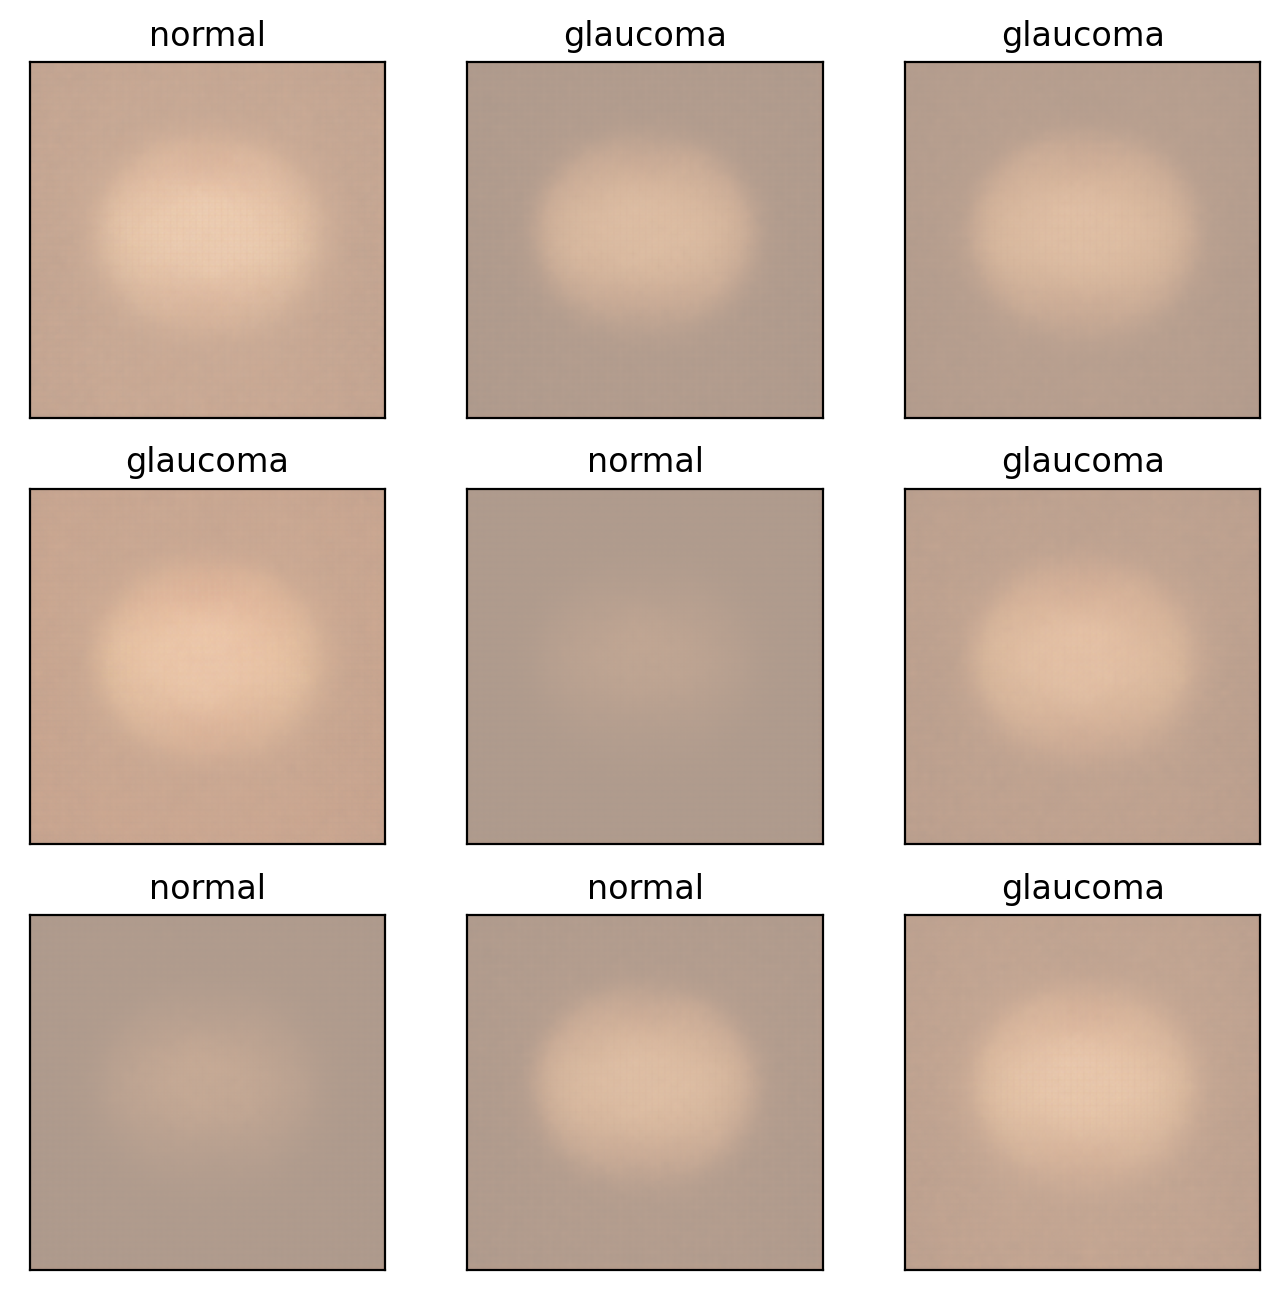

In [12]:
#Obtain one batch of training images
dataiter = iter(train_loader)
data, labels = dataiter.next()
images,_,_ = best_model(Variable(data).cuda())
images = images.detach().cpu().numpy() # convert images to numpy for display

#Plot the images
fig = plt.figure(figsize=(8, 8))
# display 20 images
for idx in np.arange(9):
    ax = fig.add_subplot(3, 3, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

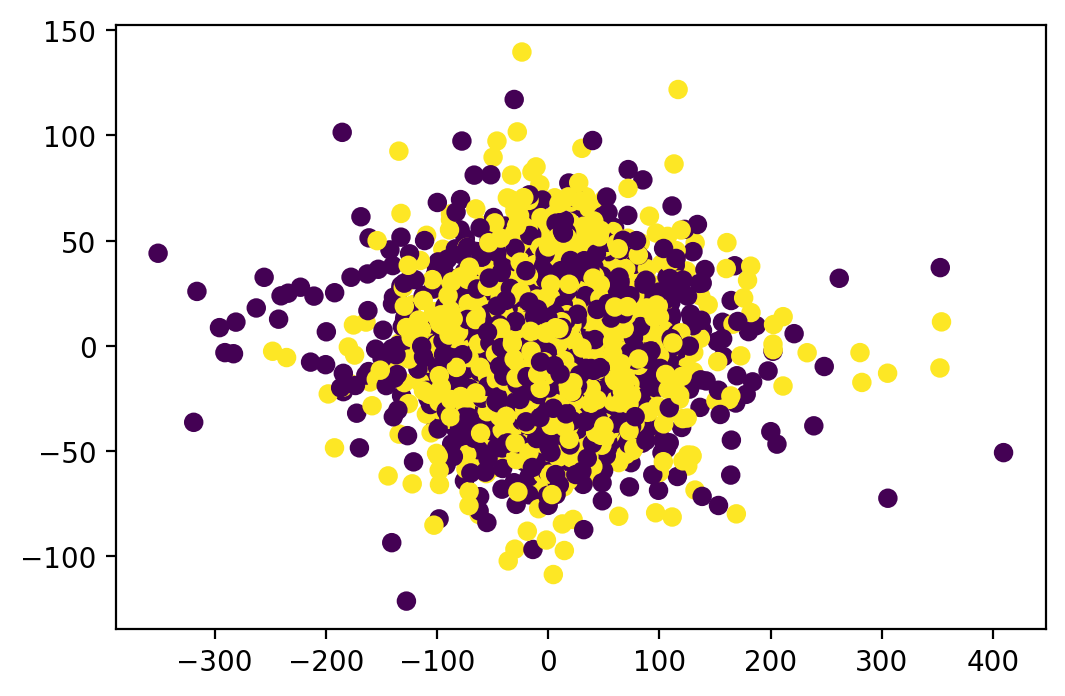

In [15]:
for i, (data,label) in enumerate(train_loader):
    y, _,_ =  best_model.encode(Variable(data).cuda())
    y = y.cpu().detach().numpy()
    plt.scatter(y[:,0],y[:,1],c=label)
plt.show()